In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons
from matplotlib.colors import ListedColormap


In [2]:
batch_size = 32
h = .02  # step size in the mesh
cm_bright = ListedColormap(['#FF0000', '#0000FF'])


In [8]:

class MLP(object):
  def __init__(self):
    self.x_input = tf.placeholder(tf.float32, shape=[None, 2])
    self.y_input = tf.placeholder(tf.int64, shape=[None])

    with tf.variable_scope('MLP_VARS'):
      dense1 = tf.layers.dense(inputs=self.x_input, units=100, activation=tf.nn.relu)
      dense2 = tf.layers.dense(inputs=dense1, units=100, activation=tf.nn.relu)
      self.logit = tf.squeeze(tf.layers.dense(inputs=dense2, units=1))

      y_xent = tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.cast(self.y_input, tf.float32),
                                                       logits=self.logit)

      self.xent = tf.reduce_mean(y_xent)

      self.predictions = tf.cast(self.logit > 0, tf.int64)

      correct_prediction = tf.equal(self.predictions, self.y_input)

      self.num_correct = tf.reduce_sum(tf.cast(correct_prediction, tf.int64))
      self.accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

      true_positives = tf.bitwise.bitwise_and(self.y_input, self.predictions)
      self.true_positive_rate = tf.reduce_sum(true_positives) / tf.reduce_sum(self.y_input)

      false_positives = tf.bitwise.bitwise_and(1 - self.y_input, self.predictions)
      self.false_positive_rate = tf.reduce_sum(false_positives) / tf.reduce_sum(1 - self.y_input)

      # self.x_input_nat = tf.boolean_mask(self.x_input, tf.equal(self.y_input, 0))
      # self.x_input_adv = tf.boolean_mask(self.x_input, tf.equal(self.y_input, 1))


In [9]:
x, y = make_moons(noise=0.3, random_state=0, n_samples=100)
x = StandardScaler().fit_transform(x)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.3)
# scaler = StandardScaler()
# x_train = scaler.fit_transform(x_train)
# x_test = scaler.transform(x_test)

x_min, x_max = x_train[:, 0].min() - .5, x_train[:, 0].max() + .5
y_min, y_max = x_train[:, 1].min() - .5, x_train[:, 1].max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

tf.reset_default_graph()
model = MLP()

global_step = tf.train.get_or_create_global_step()
train_step = tf.train.AdamOptimizer(5e-4).minimize(model.xent, global_step=global_step)

model_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='MLP_VARS')
detection_model_saver = tf.train.Saver(var_list=model_vars, max_to_keep=3)

with tf.Session() as sess:
  sess.run(tf.global_variables_initializer())
  for epoch in range(200):
    perm = np.random.permutation(x_train.shape[0])
    x_train, y_train = x_train[perm], y_train[perm]
    for i in range(0, x_train.shape[0], batch_size):
      x_batch = x_train[i: i + batch_size]
      y_batch = y_train[i: i + batch_size]
      _, acc = sess.run([train_step, model.accuracy], feed_dict={model.x_input: x_batch, model.y_input: y_batch})
      # print('training epoch {}, iter {}, acc {:.3f}'.format(epoch, i, acc))

    _, test_acc = sess.run([train_step, model.accuracy], feed_dict={model.x_input: x_test, model.y_input: y_test})
    if epoch % 10 == 0:
      print('testing epoch {}, acc {:.3f}'.format(epoch, test_acc))

  zz = sess.run(model.logit, feed_dict={model.x_input: np.c_[xx.ravel(), yy.ravel()]})
  zz = zz.reshape(xx.shape)

testing epoch 0, acc 0.567
testing epoch 10, acc 0.933
testing epoch 20, acc 0.933
testing epoch 30, acc 0.933
testing epoch 40, acc 0.900
testing epoch 50, acc 0.933
testing epoch 60, acc 0.933
testing epoch 70, acc 0.933
testing epoch 80, acc 0.933
testing epoch 90, acc 0.933
testing epoch 100, acc 0.933
testing epoch 110, acc 0.933
testing epoch 120, acc 0.933
testing epoch 130, acc 0.933
testing epoch 140, acc 0.933
testing epoch 150, acc 0.933
testing epoch 160, acc 0.933
testing epoch 170, acc 0.933
testing epoch 180, acc 0.967
testing epoch 190, acc 0.967


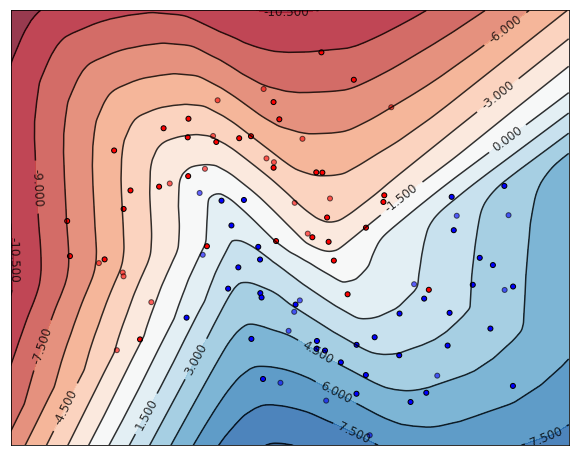

In [13]:
figure = plt.figure(figsize=(10, 8))
ax = plt.subplot(1, 1, 1)
CS = ax.contour(xx, yy, zz, 15, colors='k', alpha=.8, linestyles='solid')
ax.clabel(CS, inline=1, fontsize=12)
ax.contourf(xx, yy, zz, 15, cmap='RdBu', alpha=.8)

# Plot also the training points
ax.scatter(x_train[:, 0], x_train[:, 1], c=y_train, cmap=cm_bright,
           edgecolors='black', s=25)
# and testing points
ax.scatter(x_test[:, 0], x_test[:, 1], c=y_test, cmap=cm_bright,
           alpha=0.6, edgecolors='black', s=25)

ax.set_xlim(xx.min(), xx.max())
ax.set_ylim(yy.min(), yy.max())
ax.set_xticks(())
ax.set_yticks(())
plt.show()
